
<center>
<img src="logoCHIVO-h260.png" />
<h1> Advanced Computing for Astronomy Library (ACALib) </h1>
<b>Mauricio Araya, Martín Villanueva, Camilo Valenzuela, Axel Simonsen, Marcelo Jara, Teodoro Hochfarber, Manuel Sanchez, Gonzalo Moya.</b>


<img src="contrib.png"/>
</center>




# What is ACALib


## ACAlib is:
* a ChiVO library, 
* written in Python,
* focused on simple use of advanced computing.

## With advanced computing we refer to:
* advanced high-level astronomical algorithms,
* VO-compatible in terms of data access and application layers,
* parallel support for high-performance computing (e.g., MPI).




## Loading the library

**Goal:** Only one import 

In [1]:
%matplotlib inline
import sys
sys.path.append('../')

from acalib import *


# Data in ACALib

**Goal:** Magical data loading
* FITS (yes) 
* VoTable (partially)
* MS (not yet)
* HDF5 (not yet)
* ASDF, ASDM? 

## Astronomy file formats are basically *containers* of:
1. Tables + Metadata
2. N-dimensional Images + Metadata
3. *Optional*: Hierarchical relations

## Our container has
* A `primary` astropy image (NDData) 
* A `images` list of astropy n-dimensional images (NDData) 
* A `tables` list of astropy tables (Table)

Let us load the Orion methanol line


In [2]:
binpath = '../bindata/fits/cubes/'

# Data from ALMA science verification 
orion_path = binpath + 'Orion.methanol.cbc.contsub.image.fits'
container = load_fits(orion_path)
orion     = container.primary

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]


In [3]:
# Check Data

# Visualization

**Goal**: Try to easily *preview* data, not to make paper-ready images.

## The Visualize Function

The function `visualize()` use the *best effort* approach to visualize almost any data, from 1D to 3D.

In [4]:
# This import should be removed in some point
from acalib.io.graph import *
#visualize(orion)

### 3D contours

In [5]:
#visualize(orion,contour=True)

### 2D Visualization
Here we compute the zeroth moment using the `moment0()` function:
$$ M_0 = \sum_i I_i $$
were $I_i$ is the image at the $i$'th frequency, and visualize the result. We can also add contours to it.

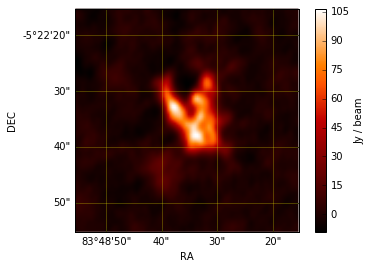

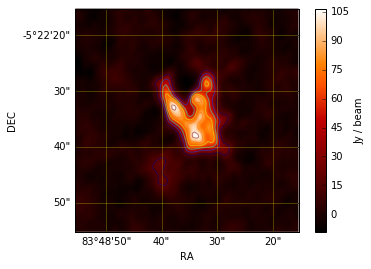

In [6]:
m0 = moment0(orion)
visualize(m0)
visualize(m0,contour=True)

## Missing data

ACALib support images with masks.
Let us also load an observation of the M100 galaxy in Band 3

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]


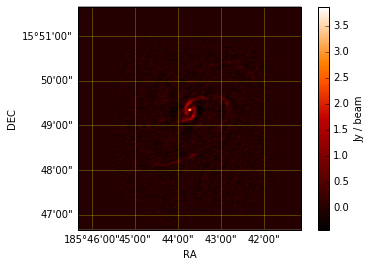

In [7]:
m100_path  = binpath + 'M100line.image.fits'
container = load_fits(m100_path)
M100      = container.primary
visualize(moment0(M100))
#visualize(M100)

## Spectrum visualization
**Warning**: this functionality is very experimental yet!

Here we compute an spectrum using the `spectra()` function, giving the position and aperture in *pixels*

In [8]:
M100.wcs.celestial.printwcs()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 185.72874999999999  15.81944444444  
CRPIX : 301.0  301.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0001388888888889  0.0001388888888889  
NAXIS    : 600 600


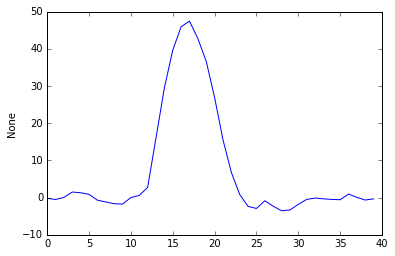

In [9]:
pos       = [301,301]*u.pix
ape       = 10*u.pix
m100_line = spectra(M100,position=pos,aperture=ape)
visualize(m100_line)

# Data Manipulation

## Other Moments
* We can use `moment1()` to compute:
$$M_1 = \frac{\sum_i I_i v_i}{M_0} $$
were $v_i$ is the velocity value at the $i$'th frequency (given a rest frequency).
* We can use `moment2()` to compute:
$$M_2 = \sqrt{\frac{\sum_i I_i (v_i - M_1)^2}{M_0}} $$


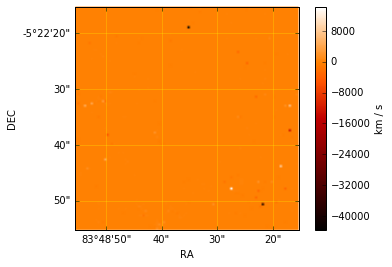

../acalib/core/utils.py:66: RuntimeWarning: invalid value encountered in sqrt
  m2=np.sqrt(beta*var/m0 - m1*m1)


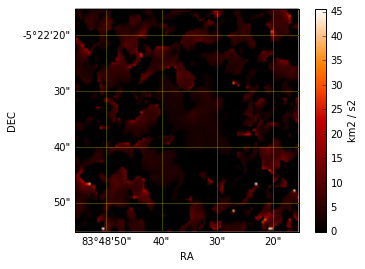

In [10]:
visualize(moment1(orion))
visualize(moment2(orion))

## Simple Denoising

We can compute the RMS using `estimate_rms()` and denoise using function `denoise()`. We can visualize the moments again.

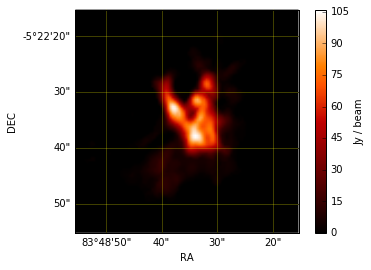

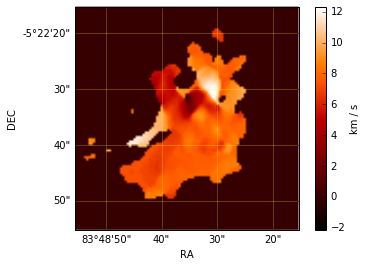

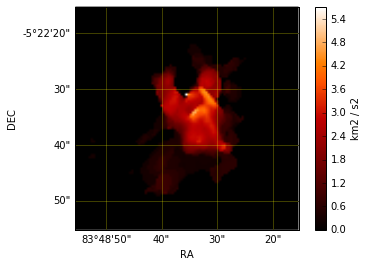

In [11]:
rms       = estimate_rms(orion)
den_orion = denoise(orion,threshold=1.5*rms)
visualize(moment0(den_orion))
visualize(moment1(den_orion))
visualize(moment2(den_orion))

## The M100 example
With and without contours

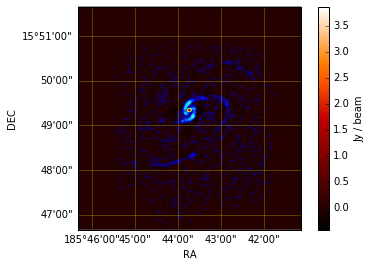

../acalib/core/utils.py:115: RuntimeWarning: invalid value encountered in greater
  elms=data>threshold


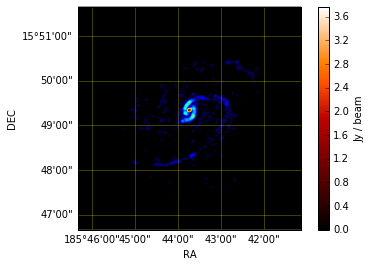

In [12]:
rms  = estimate_rms(M100)
visualize(moment0(M100),contour=True)
den_M100 = denoise(M100,threshold=2.0*rms)
visualize(moment0(den_M100),contour=True)
#visualize(den_M100,contour=True)


## Functions parameters
Functions have several default parameters, but they can be changed.
For example, the WCS includes a rest frequency to compute the radial velocity.
We can change this for the first moment.

Rest Freq = 115.2712018 GHz


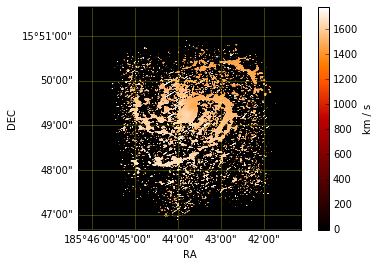

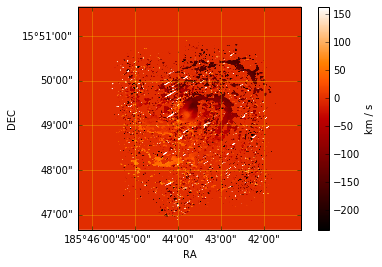

In [13]:
rfreq = den_M100.wcs.wcs.restfrq*u.Hz
print "Rest Freq =", rfreq.to(u.GHz)
visualize(moment1(den_M100))
visualize(moment1(den_M100,restfrq=114.65*u.GHz))

## Cut and Save
We can extract a subcube easily

In [14]:
M100.wcs.printwcs()

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  
CRVAL : 185.72874999999999  15.81944444444  114587503125.0  
CRPIX : 301.0  301.0  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.0001388888888889  0.0001388888888889  3906250.0  
NAXIS    : 600 600


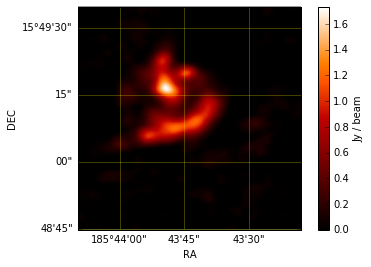

In [15]:
lb=[10,250,250]
ub=[20,350,350]
M100cut = cut(den_M100,lower=lb,upper=ub)
visualize(moment0(M100cut))
#visualize(M100cut,contour=True)

In [16]:
new_cont = Container()
new_cont.primary=M100cut
new_cont.save_fits("M100cut.fits")

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 3D data detected: assuming RA-DEC-FREQ [acalib.io.fits]


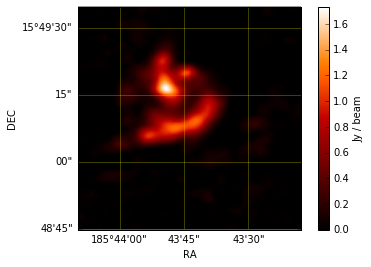

In [17]:
other_cont = load_fits("M100cut.fits")
element  = other_cont.primary
#print o_cut.wcs.wcs
elementM0   = moment0(element)
visualize(elementM0)

# Synthetic Data
## Methanol Cloud

In [18]:
from acalib.synthetic import *

center   = [186.3,15.3]*u.deg
temp     = 300*u.K
rad_vel  = 150*u.km/u.s

univ=Universe()
univ.create_source('Methcloud',center)

# Defines a new component
mol_list = {'33SO2':[1.0,10.0]* u.Jy/u.beam}
offset   = [0,0]*u.arcsec
std      = [10,7]*u.arcsec
angle    = np.pi/9.*u.rad
fwhm     = 30*u.km/u.s
gradient = [0.0,0.0]*u.km/(u.s*u.arcsec)

# Create Component
model=GaussianIMC(mol_list,temp,offset,std,angle,fwhm,gradient)
model.set_velocity(rad_vel)
univ.add_component('Methcloud',model)


INFO: Source 'Methcloud' added
 [acalib.synthetic.vu]
INFO: Added component Methcloud::1 with model species = {'33SO2': <Quantity [  1., 10.] Jy / beam>} temp = 300.0 K offset = [ 0.  0.] deg std = [ 10.   7.] arcsec angle = 0.349065850399 rad fwhm = 30.0 km / s  gradient = [ 0.  0.] km / (arcsec s) [acalib.synthetic.vu]


In [19]:
# Create Cube
ang_res = [3.0,3.0]*u.arcsec
fov     = [200,200]*u.arcsec
freq    = 299.898*u.GHz
spe_res = 0.002*u.GHz
bw      = 0.2*u.GHz
noise   = 0.001*u.Jy/u.beam

cont = univ.gen_cube(center, ang_res, fov, freq, spe_res, bw, noise,noise/50.0)

INFO: Projecting source Methcloud [acalib.synthetic.vu]
INFO: Projecting Source at [ 186.3   15.3] deg [acalib.synthetic.vu]
INFO: Projecting Methcloud::1 [acalib.synthetic.vu]
SELECT * FROM Lines WHERE SPECIES like '33SO2' AND FREQ > 299649.034235 AND FREQ < 299848.934191
INFO:    - Projecting Sulfur Dioxide (33SO2) at freq=299892.021797 MHz(299742.0095 MHz) intens=0.000542422420712 Jy / beam [acalib.synthetic.imc]
INFO:     - Discarding 33SO2 at freq=299892.06842 MHz(299742.0561 MHz) because I=1.52208053669e-06 Jy / beam < 2e-05 Jy / beam [acalib.synthetic.imc]
INFO:     - Discarding 33SO2 at freq=299892.346059 MHz(299742.3336 MHz) because I=1.52208053669e-06 Jy / beam < 2e-05 Jy / beam [acalib.synthetic.imc]
INFO:    - Projecting Sulfur Dioxide (33SO2) at freq=299892.392782 MHz(299742.3803 MHz) intens=0.000522321174954 Jy / beam [acalib.synthetic.imc]
INFO:     - Discarding 33SO2 at freq=299895.154664 MHz(299745.1408 MHz) because I=1.14245160325e-06 Jy / beam < 2e-05 Jy / beam [acal

/usr/lib/python2.7/dist-packages/astropy/units/quantity.py:763: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return super(Quantity, self).__eq__(other)


## Visualize the Gaussian

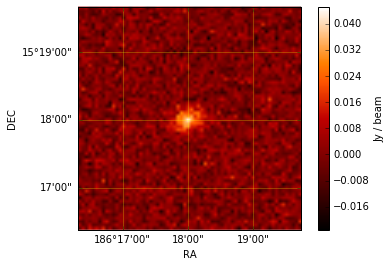

/usr/lib/python2.7/dist-packages/traits/has_traits.py:1541: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  setattr( self, name, value )


In [20]:
synthetic=cont.primary
visualize(moment0(synthetic))
#visualize(synthetic)

In [21]:
# Defines a new component
mol_list = {'33SO2': [0.5,5.0]* u.Jy/u.beam}
offset   = [20,-20]*u.arcsec
std      = [4,12]*u.arcsec
angle    = np.pi/4.*u.rad
fwhm     = 10*u.km/u.s
gradient = [-1.0,1.0]*u.km/(u.s*u.arcsec)
# Create Component
model=GaussianIMC(mol_list,temp,offset,std,angle,fwhm,gradient)
model.set_velocity(rad_vel)
univ.add_component('Methcloud',model)

# Defines a new component
mol_list = {'33SO2':[0.5,8.0]* u.Jy/u.beam}
offset   = [-20,20]*u.arcsec
std      = [4,12]*u.arcsec
angle    = np.pi/6.*u.rad
fwhm     = 10*u.km/u.s
gradient = [1.0,-1.0]*u.km/(u.s*u.arcsec)

# Create Component
model=GaussianIMC(mol_list,temp,offset,std,angle,fwhm,gradient)
model.set_velocity(rad_vel)
univ.add_component('Methcloud',model)


INFO: Added component Methcloud::2 with model species = {'33SO2': <Quantity [ 0.5, 5. ] Jy / beam>} temp = 300.0 K offset = [ 0.00555556 -0.00555556] deg std = [  4.  12.] arcsec angle = 0.785398163397 rad fwhm = 10.0 km / s  gradient = [-1.  1.] km / (arcsec s) [acalib.synthetic.vu]
INFO: Added component Methcloud::3 with model species = {'33SO2': <Quantity [ 0.5, 8. ] Jy / beam>} temp = 300.0 K offset = [-0.00555556  0.00555556] deg std = [  4.  12.] arcsec angle = 0.523598775598 rad fwhm = 10.0 km / s  gradient = [ 1. -1.] km / (arcsec s) [acalib.synthetic.vu]


In [29]:
# Create Cube
ang_res = [3.0,3.0]*u.arcsec
fov     = [200,200]*u.arcsec
freq    = 299.898*u.GHz
spe_res = 0.002*u.GHz
bw      = 0.2*u.GHz
noise   = 0.001*u.Jy/u.beam

cont = univ.gen_cube(center, ang_res, fov, freq, spe_res, bw, noise,noise/50.0)

INFO: Projecting source Methcloud [acalib.synthetic.vu]
INFO: Projecting Source at [ 186.3   15.3] deg [acalib.synthetic.vu]
INFO: Projecting Methcloud::1 [acalib.synthetic.vu]
SELECT * FROM Lines WHERE SPECIES like '33SO2' AND FREQ > 299649.034235 AND FREQ < 299848.934191
INFO:    - Projecting Sulfur Dioxide (33SO2) at freq=299892.021797 MHz(299742.0095 MHz) intens=0.00140738863828 Jy / beam [acalib.synthetic.imc]
INFO:     - Discarding 33SO2 at freq=299892.06842 MHz(299742.0561 MHz) because I=3.94924467e-06 Jy / beam < 2e-05 Jy / beam [acalib.synthetic.imc]
INFO:     - Discarding 33SO2 at freq=299892.346059 MHz(299742.3336 MHz) because I=3.94924467e-06 Jy / beam < 2e-05 Jy / beam [acalib.synthetic.imc]
INFO:    - Projecting Sulfur Dioxide (33SO2) at freq=299892.392782 MHz(299742.3803 MHz) intens=0.00135523322616 Jy / beam [acalib.synthetic.imc]
INFO:     - Discarding 33SO2 at freq=299895.154664 MHz(299745.1408 MHz) because I=2.96424584384e-06 Jy / beam < 2e-05 Jy / beam [acalib.synth

## Denoise and Visualize

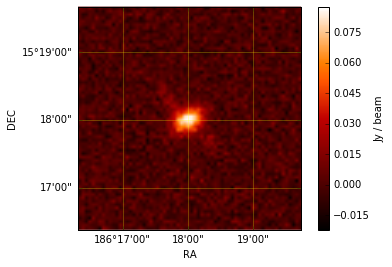

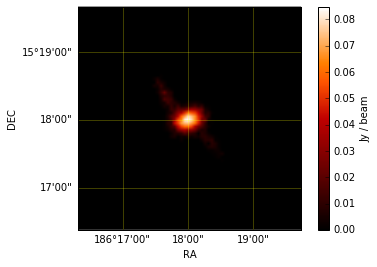

In [30]:
synthetic=cont.primary
visualize(moment0(synthetic))
syden=denoise(synthetic,threshold=2.0*estimate_rms(synthetic))
visualize(moment0(syden))
#visualize(syden,contour=True)

## Metadata

In [25]:
cont.tables[0]

Source Name,Comp ID,Model,Alpha,Delta,Redshift,Radial Vel
str80,str80,str40,float64,float64,float64,float64
Methcloud,Methcloud::1,Gaussian IMC,186.3,15.3,0.000500471378582,150000.0
Methcloud,Methcloud::2,Gaussian IMC,186.294444444,15.3055555556,0.000500471378582,150000.0
Methcloud,Methcloud::3,Gaussian IMC,186.305555556,15.2944444444,0.000500471378582,150000.0


In [28]:
cont.tables[2]

Line Code,Mol,Ch Name,Rest Freq,Obs Freq,Intensity
str80,str40,str40,float64,float64,float64
Methcloud::2-l1,33SO2,Sulfur Dioxide,299742.0095,299892.021797,0.000664831821261
Methcloud::2-l4,33SO2,Sulfur Dioxide,299742.3803,299892.392782,0.000640194292803
Methcloud::2-l9,33SO2,Sulfur Dioxide,299748.6847,299898.700337,0.000691531515347
Methcloud::2-l10,33SO2,Sulfur Dioxide,299749.0412,299899.057016,0.000617322316367


# Algorithms

## ROI Detection

## Clump Detection (CUPID)

# What Next?

## More libraries!
* *2D imaging*     : Glue, AplPy ?
* *Dendograms*     : Astrodendro
* *Radioastronomy* : CASA (casacore)
* *(put your library here)*